In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters
from lmfit.model import ModelResult
from lmfit.models import PolynomialModel
from tqdm.auto import tqdm
# import ray
# from ray.exceptions import GetTimeoutError
from rdkit import Chem
# import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime as dt
from pathlib import Path

In [2]:
def remove_frame(ax, sides=["top", "left", "right"]):
    """Remove the frame of a matplotlib plot"""
    for side in sides:
        ax_side = ax.spines[side]
        ax_side.set_visible(False)

In [3]:
def calculate_activity_coefficients_polynomial(
    preds: pd.DataFrame, order=4
):
    # c1_0 is parameter 1 (zero-indexed) for molecule 1
    for i in range(2):
        preds[f"ln_gamma_{i+1}_pred"] = 0
        for j in range(order+1):
            x = preds["x(1)"] if i == 0 else 1.0-preds["x(1)"]
            preds[f"ln_gamma_{i+1}_pred"] += preds[f"c{j}_{i}"]*x**j
    return preds

In [4]:
# NRTL data
results_path = Path("../data/02_intermediate/cosmo/nrtl_parameters")
assert results_path.exists()
files = results_path.glob("./batch_*.csv")
files_dummy = [_ for _ in files]
files = results_path.glob("./batch_*.csv")
nrtl_df = pd.concat([pd.read_csv(file, index_col=0) for file in files])

In [5]:
# Polynomial data
polynomial_df = pd.read_parquet("../data/03_primary/polynomial_good_fit_all.pq")

In [6]:
polynomial_df = calculate_activity_coefficients_polynomial(polynomial_df)

In [7]:
for i in [1,2]:
    polynomial_df[f"error_ln_gamma_{i}"] = (
        polynomial_df[f"ln_gamma_{i}"] - polynomial_df[f"ln_gamma_{i}_pred"]
    )
    polynomial_df[f"ln_gamma_{i}_mae"] = polynomial_df[f"error_ln_gamma_{i}"].abs()

In [13]:
polynomial_df_compressed = polynomial_df.groupby(
    ["smiles_1", "smiles_2", "temperature (K)"]
).mean().reset_index()

In [14]:
nrtl_df.columns

Index(['smiles_1', 'smiles_2', 'temperature (K)', 'time', 'alpha_12',
       'alpha_21', 'tau_12', 'tau_21', 'ln_gamma_1_mae', 'ln_gamma_2_mae'],
      dtype='object')

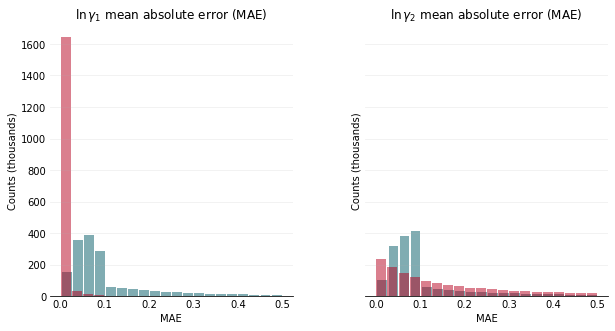

In [17]:
import matplotlib.ticker as ticker
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
fig.subplots_adjust(wspace=0.5)
colors = ["#025b66", "#b7001e"]
for j, df in enumerate([nrtl_df, polynomial_df_compressed]):
    for ax, i in zip(axes, [1,2]):
        df[df[f"ln_gamma_{i}_mae"]<0.5].hist(
            f"ln_gamma_{i}_mae",
            grid=False, ax=ax,
            bins=20, 
            rwidth=0.9, 
            color=colors[j],
            alpha=0.5
        )
        ax.grid(axis="y", alpha=0.2)
        ax.tick_params(length=0)
        ax.set_title(f"$\ln \gamma_{i}$ mean absolute error (MAE)")
        ax.set_xlabel("MAE")
        ax.set_ylabel("Counts (thousands)")
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda y, pos: '%.0f' % (y * 1e-3)))
        remove_frame(ax)
fig.savefig("../data/08_reporting/error_distribution_fitting_cosmo.png", dpi=300)